In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm
import pandas as pd
from PIL import Image
import cairosvg
import io
import numpy as np
import joblib
import cortex
from neuro import config
from collections import defaultdict
import matplotlib.pyplot as plt
from neuro import analyze_helper
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from matplotlib.gridspec import GridSpec
from neuro.features.questions.gpt4 import QS_35_STABLE
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import viz
config.setup_freesurfer()
def load_img_array(img_path, add_overlay_S02_with_text=False, add_overlay_S02_without_text=False):
    img = Image.open(img_path).convert("RGBA")
    if add_overlay_S02_with_text:
        svg_path = join('save_flatmaps', 'S02_overlay_with_text.svg')
    elif add_overlay_S02_without_text:
        svg_path = join('save_flatmaps', 'S02_overlay_without_text.svg')
    else:
        svg_path = None
    if svg_path:
        svg_png_data = cairosvg.svg2png(url=svg_path, output_width=img.width, output_height=img.height)
        overlay = Image.open(io.BytesIO(svg_png_data)).convert("RGBA")

        # Overlay SVG on top of PNG
        img = Image.alpha_composite(img, overlay)
    return np.array(img)

subject = 'S02'
subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
# subjects = ['S01', 'S02', 'S03']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### neurosynth flatmaps

In [ ]:
subj_vols = []
for term in ['place', 'location']:  # , 'locations']:
    mni_filename = join(config.NEUROSYNTH_DATA_DIR,
                        f'all_association-test_z/{term}_association-test_z.nii.gz')
    mni_vol = cortex.Volume(mni_filename, "fsaverage", "atlas_2mm")
    subj_vol, subj_arr = neurosynth.mni_vol_to_subj_vol_surf(
        mni_vol, subject=subject)
    print('mni shape', mni_vol.shape, 'subj shape',
          subj_vol.shape, 'subj_arr shape', subj_arr.shape)

    neuro.sasc.viz.quickshow(
        subj_vol.data,
        subject='UT' + subject,
        fname_save=join(f'intersubject/{term}_subj.png'),
        with_colorbar=False,
    )
    neuro.sasc.viz.quickshow(
        mni_vol,
        subject='fsaverage',
        fname_save=join(f'intersubject/{term}_mni.png'),
        with_colorbar=False,
    )
    subj_vols.append(subj_vol.data)

neuro.sasc.viz.quickshow(
    np.array(subj_vols).mean(axis=0),
    subject='UT' + subject,
    fname_save=join(f'intersubject/avg_subj.png'),
    with_colorbar=False,
)

### individual subject qa-35 flatmaps

In [ ]:
# qs = ['Does the sentence mention a specific location?']
for q in tqdm(QS_35_STABLE):
    for subject in ['S02', 'S01', 'S03']: #['S01', 'S02', 'S03']:  # ['S01', 'S02', 'S03']:
        # if subject in ['S03']:
        # settings = ['individual_gpt4', 'individual_gpt4_wordrate', 'shapley_35']
        # settings = ['shapley_35']
        # else:
        settings = ['individual_gpt4_pc_new']
        flatmaps_qa_list = defaultdict(list)
        for setting in settings:
            flatmaps_qa_dict = joblib.load(
                join(config.PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
        flatmaps_qa_dict = {
            q: np.mean(flatmaps_qa_list[q], axis=0)
            for q in flatmaps_qa_list.keys()}

        print('visualizing...')
        neuro.viz.quickshow(
            flatmaps_qa_dict[q],
            subject='UT'+subject,
            fname_save=join('save_flatmaps', subject, q + '.pdf'),
            with_colorbar=False,
            # kwargs={'with_rois': False},
            kwargs={'with_rois': True, 'roi_list': ['AC', 'Broca', 'PPA', 'RSC'], 'with_labels': False, 'linecolor': 'black',},
            # cmap='RdYlBu_r',
        )

In [ ]:
# save a RedBlue horizontal colorbar
def save_colorbar(cmap, norm, orientation='horizontal', filename='colorbar.png'):
    if orientation == 'vertical':
        fig, ax = plt.subplots(figsize=(0.5, 2.5))
        fig.subplots_adjust(left=0.5)
    else:
        fig, ax = plt.subplots(figsize=(2.5, 0.5))
        fig.subplots_adjust(bottom=0.5)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation=orientation)
    cbar.set_label('Normalized weight')
    plt.savefig(filename, bbox_inches='tight', dpi=300, transparent=True)
    plt.close(fig)


cmap = cm.RdBu_r
norm = Normalize(vmin=-1, vmax=1)
save_colorbar(cmap, norm, orientation='horizontal',
              filename='colorbar_norm.png')
save_colorbar(cmap, norm, orientation='vertical',
              filename='colorbar_norm_vert.png')

### full-cortex grid

In [ ]:
# save flatmaps into a grid
for subject in ['S02', 'S01', 'S03']:
    C = 5
    R = 7
    fig, axs = plt.subplots(R, C, figsize=(12, 10))
    for i, q in enumerate(QS_35_STABLE):
        img = mpimg.imread(
            join('save_flatmaps', subject, q + '.png'))
        axs[i//C, i % C].imshow(img)
        # axs[i//C, i % C].axis('off')
        axs[i//C, i % C].set_title(analyze_helper.abbrev_question(q), fontsize='x-small')
    for i in range(R * C):
        axs[i//C, i % C].axis('off')
    plt.tight_layout()
    plt.savefig(join(
        'save_flatmaps', subject + '_grid.pdf'))

### left-hem grid single-subject with englarged first plot

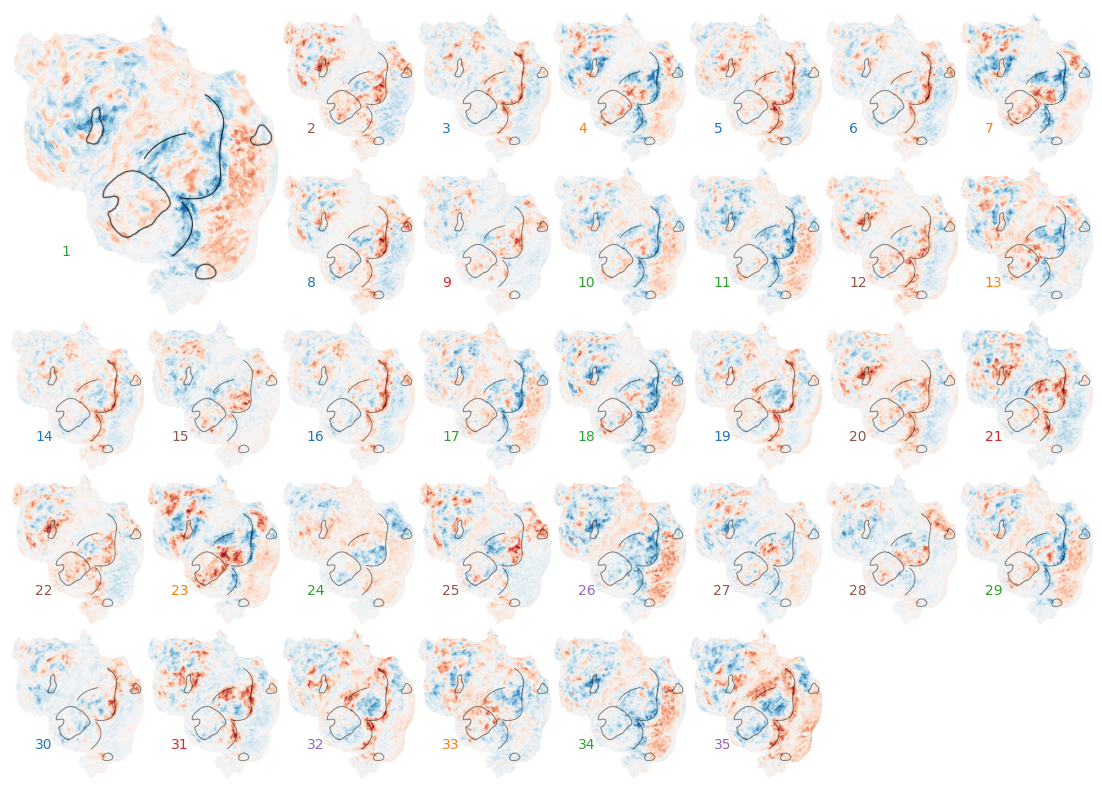

In [6]:
# load and sort questions
survey_df = pd.read_pickle('monosemantic/single_question_perf_and_survey.pkl').sort_values(by='Average', ascending=False)
question_order = survey_df['question_abbrev']
QUESTION_ORDER = list(question_order[question_order.isin([analyze_helper.abbrev_question(q) for q in QS_35_STABLE])].values)

# Questions to exclude from visualization
EXCLUDE_QUESTIONS = [
    # Add questions you want to exclude here, e.g.:
    # "Does the sentence mention a specific location?",
    # "Does the sentence describe an action?",
]

# Filter out excluded questions
QS_FILTERED = [q for q in QS_35_STABLE if q not in EXCLUDE_QUESTIONS]

tab10 = plt.get_cmap('tab10')
q_to_idx = {analyze_helper.abbrev_question(q): i for (q,i) in viz.REMAP_QUESTIONS_TO_CATEGORY_IDXS.items()}
n_colors = len(set(q_to_idx.values()))
colors = [tab10(i) for i in range(n_colors)]

for subject in ['S02']:
    R, C = 5, 8
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(R, C, figure=fig, hspace=0, wspace=0)

    axs = {}

    # Create large top-left plot (2x2)
    axs[0] = fig.add_subplot(gs[0:2, 0:2])  # Reserve (0,0),(0,1),(1,0),(1,1) for first plot

    # Generate list of remaining positions, skipping the 2x2 block
    occupied = set((r, c) for r in range(2) for c in range(2))
    plot_positions = [(r, c) for r in range(R) for c in range(C) if (r, c) not in occupied]

    for i, q in enumerate(QS_FILTERED):
        abbr = analyze_helper.abbrev_question(q)
        
    
        if i == 0:
            ax = axs[0]
            img = load_img_array(
                join('save_flatmaps', subject, q + '.png'),
                add_overlay_S02_without_text=True,
            )
        else:
            r, c = plot_positions[i - 1]
            ax = fig.add_subplot(gs[r, c])
            img = load_img_array(
                join('save_flatmaps', subject, q + '.png'),
                add_overlay_S02_without_text=True,
            )
        
        img = img[:, :int(img.shape[1] * 0.475), :]
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.19, 0.2, str(i + 1),
                transform=ax.transAxes,
                color=colors[q_to_idx[abbr]])

    plt.savefig(join('save_flatmaps', subject + '_half_grid.pdf'), bbox_inches='tight', dpi=300, transparent=True)
    plt.savefig(join('save_flatmaps', subject + '_half_grid.png'), bbox_inches='tight', dpi=300, transparent=True)

### left-hem grid multi-subject

In [ ]:
# Create the outer 3x5 grid
fig = plt.figure(figsize=(15, 9))
outer_grid = gridspec.GridSpec(7, 5, wspace=0.05, hspace=0)

# Loop over each cell in the outer grid
for i in range(7):  # rows
    for j in range(5):  # columns
        idx = i * 5 + j
        q = QS_35_STABLE[idx]
        # Create a subgridspec inside each outer panel with 1 row and 3 columns
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            1, 3, subplot_spec=outer_grid[i, j], wspace=0
        )
        for k, subject in enumerate(['S01', 'S02', 'S03']):
            ax = plt.Subplot(fig, inner_grid[0, k])
            img = mpimg.imread(
                join('save_flatmaps', subject, q + '.png'))
            subj_frac = {
                'S01': 0.44,
                'S02': 0.475,
                'S03': 0.485,
            }
            img = img[:, :int(img.shape[1] * subj_frac[subject]), :]
            ax.imshow(img)
            fig.add_subplot(ax)
            ax.axis('off')

        # add title
        bbox = outer_grid[i, j].get_position(fig)
        fig.text(
            x=(bbox.x0 + bbox.x1) / 2,
            y=bbox.y1 - 0.01,
            s=analyze_helper.abbrev_question(q),
            ha='center',
            va='bottom',
            fontsize='xx-small',
            # fontweight='bold'
        )

plt.tight_layout()
plt.savefig(join('save_flatmaps', 'multisubject_half_grid.pdf'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### gct flatmaps

In [ ]:
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps(
    normalize_flatmaps=False, load_timecourse=False)
q_tup = ('locations', 368)
neuro.sasc.viz.quickshow(
    gemv_flatmaps_dict_S02[q_tup],
    subject='UTS02',
    fname_save=join('save_flatmaps', q_tup[0], f'gemv_S02.png'),
    with_colorbar=False,
    # cmap='RdYlBu_r',
)